# League of Legends
League of Legends è un videogioco Multiplayer Online Battle Arena (MOBA). Dieci giocatori divisi in due squadre combattono tra di loro per distruggere la base nemica.
Per gli scopi di questo progetto il riassunto non sarà esaustivo e eviterà di menzionare aspetti del gioco non inerenti al nostro studio.

La mappa su cui si svolge il gioco è la seguente

<img src="assets/league_of_legends_map.jpg" width=600/>

# In foto sono evidenziati:
## Nexus
Il Nexus è il cuore della base di una squadra, in foto è la gemma che si trova in basso a sinistra e in alto a destra per la squadra blu e rossa, rispettivamente. Il Nexus è protetto da tre inhibitor.

## Inhibitor
L'inhibitor è una struttura il cui scopo è proteggere il nexus. Una volta distrutto anche un solo inhibitor il Nexus viene scoperto e diventa vulnerabile ad attacchi nemici. Gli inhibitor sono protetti dalle torri presenti nelle lane.

## Lane
Ci sono tre corsie (lane) che partono dalla base blu e arrivano alla rossa, una in cima, in mezzo e in basso. Le corsie sono spesso occupate da giocatori che la difendono, in quanto per corsia sono presenti 2 torri per ciascuna squadra che proteggono gli Inhibitor. Una volta distrutte le due torri appartenenti ad una squadra in una lane, diventa vulnerabile l'inhibitor.

## Torre
La torre (in foto sono le statue sulle lane) è una struttura il cui scopo è proteggere la lane, per avanzare una squadra deve distruggere le torri presenti sulla lane per avanzare all'inhibitor

## Giungla
Tutto il territorio presente in mezzo alle lane, contiene mostri e obbiettivi. Gli obbiettivi appaiono a periodi prefissati nella partita, i principali sono

### Drake
Un drago appare periodicamente in basso a destra nella giungla, la squadra che lo sconfigge ottiene dei bonus

### Rift Herald
Un Rift Herald appare periodicamente verso inizio partita in alto a sinistra sulla mappa, la squadra che lo sconfigge può evocarlo per distruggere le torri nemiche

### Baron
Il Baron appare periodicamente verso fine partita, la squadra che lo sconfigge ottiene dei bonus temporanei

## Sintesi
Una squadra per vincere deve penetrare le difese di almeno una lane (torri), distruggere l'inhibitor ad esso associata e finire distruggendo il Nexus. 

## Scopo del progetto
Lo scopo del progetto è quello di studiare e trovare correlazioni e probabilità associate ai vari aspetti di una partita di League of Legends.

In [1]:
# Importazione dataset

import os
import numpy as np
from urllib.request import urlretrieve
from zipfile import ZipFile

# constants
URL = "https://www.kaggle.com/api/v1/datasets/download/datasnaek/league-of-legends"
DATA_DIR = "data/"
ZIP_NAME = "compressed.zip"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

os.chdir(os.path.join(os.getcwd(), DATA_DIR))

if not os.path.exists(ZIP_NAME):
    # scarica il file dall'URL indicato
    urlretrieve(URL, ZIP_NAME)
    # apri il file zip ed estrai tutto il contenuto nella directory corrente
    with ZipFile(ZIP_NAME) as f:
        f.extractall()

In [2]:
# Parsing dati

import pandas as pd
import json

games_data = pd.read_csv('games.csv', index_col=['gameId'])

# Carica il file
with open("champion_info.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Accedi alla parte utile dei dati (data["data"] è un dizionario con campioni)
champion_data = data["data"]

# Trasforma il dizionario in DataFrame
df_champions_keyID = pd.DataFrame.from_dict(champion_data, orient="index")
# Carica il file
with open("champion_info_2.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Accedi alla parte utile dei dati (data["data"] è un dizionario con campioni)
champion_data = data["data"]

# Trasforma il dizionario in DataFrame
df_champions_nameID = pd.DataFrame.from_dict(champion_data, orient="index")

In [3]:
# L'anima del drago è un bonus che riceve una squadra se ha ucciso almeno quattro draghi.
games_data["t1_hasDragonSoul"] = games_data["t1_dragonKills"] >= 4
games_data["t2_hasDragonSoul"] = games_data["t2_dragonKills"] >= 4

# Probabilità di vittoria condizionata
Il gioco contiene molte variabili e offre innumerevoli opzioni a ciascun giocatore, questa analisi servirà a quantificare l'impatto che hanno l'acquisizione degli obiettivi principali non solo sulla vittoria di una squadra, ma anche sull'acquisizione di altri obbiettivi (effetto palla di neve).

In seguito calcoliamo una matrice di correlazione sulle seguenti colonne:
- Winner

    Quale squadra ha vinto

- First Blood

    Quale squadra ha ottenuto il primo sangue
    
- First Tower

    Quale squadra ha distrutto la prima torre

- First Inhibitor

    Quale squadra ha distrutto il primo inhibitor
    
- First Baron

    Quale squadra ha sconfitto il primo baron
    
- First Dragon

    Quale squadra ha sconfitto il primo drago (drake)
    
- First Rift Herald

    Quale squadra ha acquisito il primo Rift Herald

- T1/T2 Has Dragon Soul

    Se la squadra 1/2 ha ottenuto l'anima del drago
    
Possiamo fare varie osservazioni sui risultati:
1. Tutte le colonne inerenti ad un obiettivo ottenuto dalla squadra sono positivamente correlate con la vittoria

    Non tutti gli obbiettivi sono uguali però: La correlazione maggiore la possiamo osservare tra primo inhibitor e vittoria (0.72), mentre la correlazione tra vittoria e First Blood è nettamente inferiore (0.18). In seguito approfondiremo questa differenza.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

corr_frame = games_data.copy()
columns = ['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_hasDragonSoul', 't2_hasDragonSoul']

# Trasformo i dati in modo da renderli più adatti all'analisi
ternary_map = {
    0: 0,
    1: 1,
    2: -1,
}

for column in columns[:-2]: # exclude soul columns
    corr_frame[column] = corr_frame[column].map(ternary_map)
    corr_frame[column] = corr_frame[column] == 1
    

corr_frame[columns].corr().style.format('{:.2f}', na_rep="")\
    .bar(align=0, vmin=-1, vmax=1, cmap="RdYlGn", height=50, width=60)

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_hasDragonSoul,t2_hasDragonSoul
winner,1.00,0.18,0.41,0.72,0.39,0.34,0.22,0.14,-0.15
firstBlood,0.18,1.00,0.22,0.16,0.06,0.14,0.11,0.03,-0.02
firstTower,0.41,0.22,1.00,0.40,0.15,0.32,0.26,0.08,-0.08
firstInhibitor,0.72,0.16,0.40,1.00,0.42,0.32,0.24,0.16,-0.11
firstBaron,0.39,0.06,0.15,0.42,1.00,0.17,0.13,0.16,-0.02
firstDragon,0.34,0.14,0.32,0.32,0.17,1.00,0.19,0.21,-0.20
firstRiftHerald,0.22,0.11,0.26,0.24,0.13,0.19,1.00,0.06,-0.04
t1_hasDragonSoul,0.14,0.03,0.08,0.16,0.16,0.21,0.06,1.00,-0.05
t2_hasDragonSoul,-0.15,-0.02,-0.08,-0.11,-0.02,-0.20,-0.04,-0.05,1.00


La probabilità condizionale di eventi la cui probabilità è calcolabile come frazione "casi favorevoli" su "cardinalità insieme universo" può essere semplificata algebricamente nel seguente modo

$$ P(x) = \dfrac{\#EvtX}{\#\Omega} $$ 
$$ P(Win) = \dfrac{\#PartiteVinte}{\#\Omega} $$
$$ P(Win|x) = \dfrac{P(Win,x)}{P(x)} = \dfrac{\dfrac{\#(PartiteVinte \cap EvtX)}{\#\Omega}}{\dfrac{\#EvtX}{\#\Omega}} = \dfrac{\#(PartiteVinte \cap EvtX)}{\#EvtX} $$

In [5]:
# Calcola vittoria condizionata alla colonna on_column
def win_conditional_prob(data: pd.DataFrame, on_column: str):
    intersect_count = len(data[(data["winner"] == 1) & (data[on_column] == 1)])
    on_column_count = len(data[data[on_column] == 1])
    
    return intersect_count / on_column_count

Calcolando le probabilità di vittoria condizionate sulle colonne che avevamo scelto prima riusciamo a quantificare l'impatto di ciascun obbiettivo.
Tra queste notiamo
- First Blood (59%)

    Il primo sangue, pur essendo un'obbiettivo a prima apparenza scarsamente influente, aumenta la probabilità di vittora del 10%. Questo è probabilmente dovuto al fatto che il giocatore che ha ottenuto il primo sangue potrà potenziare il suo personaggio, il che può portare ad un effetto "palla di neve" dove il personaggio potenziato è più forte dei suoi nemici e li sconfigge con più facilità, portandolo a potenziarsi ulteriormente in un circolo vizioso di vantaggio e oppressione della squadra nemica.
- First Inhibitor (91%)

    La distruzione del primo inhibitor invece porta la squadra che lo ottiene ad una probabilità enorme di vittoria. A differenza del primo sangue però, questo dato è da contestualizzare meglio.
    Nonostante i calcoli ci hanno permesso di concludere che la squadra che ha distrutto il primo inhibitor ha la probabilità del 91% di vincere, bisogna considerare che il fatto che una squadra sia arrivata a tale impresa significa che aveva già un vantaggio significativo sul nemico, e di conseguenza sarebbe da chiarire che la probabilità di vittoria della squadra sarebbe stata altrettanto alta anche prima che sia avvenuta la distruzione del primo inhibitor.


In [6]:
win_probabilities = pd.DataFrame(
    {
        column: win_conditional_prob(games_data, column) for column in columns[1:]
    }, index=["Win Rate"]
)
win_probabilities.style.format('{:.2f}')\
    .bar(align=0, vmin=0, vmax=1, cmap="YlGn", height=50, width=50)

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_hasDragonSoul,t2_hasDragonSoul
Win Rate,0.59,0.71,0.91,0.81,0.69,0.69,0.82,0.18


Ottenuti questi dati, ora proviamo a fare un modello di predizione di vittoria. Il modello Naive Bayes è fondato sulla presunzione che i suoi parametri sono variabili indipendenti tra di loro, non è il caso con le nostre variabili ma è risaputo che il modello riesce a performare bene anche altrimenti.

Allenato il modello riusciamo ad ottenere un f1 score soddisfacente (0.874280912675328) 

In [13]:
# Naive Bayes model for predicting win based on objectives

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

model_data = games_data.copy()

model_columns = columns[1:] + ["t1_dragonKills", "t2_dragonKills", "t1_baronKills", "t2_baronKills"]

X, y = (games_data[model_columns], games_data["winner"] == 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
win_predictor = GaussianNB()
y_pred = win_predictor.fit(X_train, y_train).predict(X_test)

f1_score(y_test, y_pred)

0.874280912675328

In seguito la sua learning curve del modello. Il veloce approccio del learning score al training score ci porta a concludere che il modello non è stato overfittato.

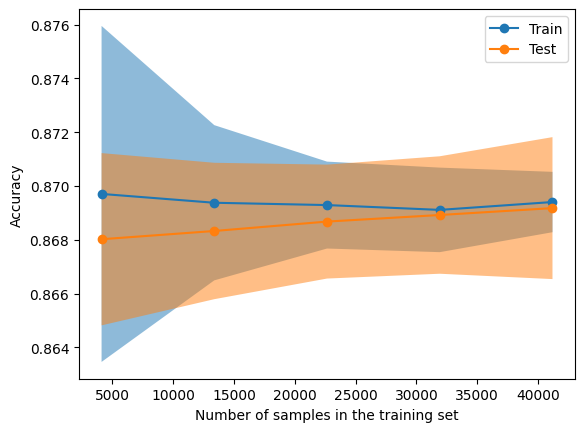

In [9]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

# learning score e training score

LearningCurveDisplay.from_estimator(
    win_predictor, 
    X = X, 
    y = y,
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = ShuffleSplit(n_splits=25, test_size=0.2, random_state=0),
    score_type = "both",
    n_jobs = 4,
    line_kw = {"marker": "o"},
    std_display_style = "fill_between",
    score_name = "Accuracy",
)